## SVR without Cluster

In [1]:
class DataSeparate:
    """
    separate dataframe follow the coin ID and standardrized input features, store all df in a list
    """ 
    def separate(self, df, col):
        """
        df: dataframe
        col: separate by which column
        """
        id_list = df[col].unique()
        id_list.sort()
        
        df_list = []
    
        for id in id_list:
            data = df[df['Asset_ID'].isin([id])]
            
            # reample the data, get target in each day
            data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
            data = data.set_index('timestamp')
            
            data_early = data['2018':'2020']
            data_early = data_early.resample(rule='3D').mean()
            
            data_late = data['2021']
            data_late = data_late.resample(rule='H').mean()
            
            data = pd.concat([data_early, data_late])
            
            data.dropna(inplace=True)
            
            df_list.append(data)
            
        return df_list

In [2]:
from sklearn.preprocessing import StandardScaler

# normalization and standardization
class Preprocess:
    def __init__(self):
        """
        store the characters valur of train data, ready for testset
        """
        self.cols = ['Count','Open','High','Low','Close','Volume']
        
    def train_std(self, df_list):
        count = 0
        
        for df in df_list:
            scaler = StandardScaler()
            df[self.cols] = scaler.fit_transform(df[self.cols])
            joblib.dump(scaler, 'scaler%s.pkl' %count)
            count += 1
        
        return df_list 
        
    def test_std(self, df):
        
        for index, row in df.iterrows():
            # load model
            num = int(row['Asset_ID'])
            test_scalar = joblib.load('scaler%s.pkl' %num)

            df.loc[index, 'Count':'Volume'] = test_scalar.transform(df.loc[index, 'Count':'Volume'].values.reshape(1,6))[0]
    
        return df

In [3]:
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.model_selection import KFold, GridSearchCV
from sklearn import metrics
import joblib

# regression for each coin
class SVRModel:
    """
    use the input model to fit the input data with k-Fold cross validation 
    """
    def fit(self, df_list):
        """
        train the model for each data frame in df_list
            df_list: a list of data frame
            model: a SVR model in this case
        return: average mse loss of all dataframes
        """
        count = 0
        
        print("Train SVR Model")
        for df in tqdm(df_list):
            
            x_train = df.loc[:,'Count':'Volume']
            y_train = df.loc[:,'Target']
            
            parameters = {'kernel':['rbf'], 
                          'gamma':[0.01], 
                          'C':np.logspace(0, 5, num=6, base=2.0), 
                          'epsilon':[0.0001],
                          'cache_size':[1000] 
                         }
            
            svr = SVR()
            grid_search = GridSearchCV(svr, 
                                       parameters, 
                                       cv=10, 
                                       n_jobs=4, 
                                       scoring='neg_mean_absolute_error',
                                       return_train_score=True
                                      )
            
            grid_search.fit(x_train, y_train)
            
            # store the model as .pkl file
            joblib.dump(grid_search, 'svr%s.pkl' %count)
            count += 1
            
            print('Mean Train score: {}'.format(grid_search.cv_results_['mean_test_score']))
            
    def pred(self, df):
        pred_df = pd.DataFrame(columns=['Target'])
        for index, row in df.iterrows():
            # load model
            num = int(row['Asset_ID'])
            test_model = joblib.load('svr%s.pkl' %num)

            x_test = df.loc[index, 'Count':'Volume'].values.reshape(1,6)
            y_pred = test_model.predict(x_test)[0]
            pred_df = pred_df.append({'Target': y_pred}, ignore_index=True)
    
        return pred_df

In [4]:
def trainer(df):
    df_list = separater.separate(df, 'Asset_ID')
    
    df_list = std_scaler.train_std(df_list)
    
    model.fit(df_list)

- since large data amount, we also need a resampling for the time serial data. resample process is in data separater

In [5]:
import copy
import numpy as np 
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# from skfuzzy.cluster import cmeans

from tqdm import tqdm
import gresearch_crypto


# import data
data_folder = "/kaggle/input/g-research-crypto-forecasting/"

# shape of ex_train_pd is (24236806, 10)
train_df = pd.read_csv(data_folder + 'train.csv')

# shape of ex_train_pd is (2015112, 10)
test_df = pd.read_csv(data_folder + 'supplemental_train.csv')

# drop lines contain NaN
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# split a testset for prediction test
# train_df, test_df = train_test_split(input_df, test_size=0.05, shuffle=False)

# random_seed = 12
# train_df = shuffle(train_df, random_state=random_seed)

In [6]:
# init data separater
separater = DataSeparate()

# init StandardScaler
std_scaler = Preprocess()

# use SVR from sklearn as model
model = SVRModel()

# train the model
trainer(train_df)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.


Train SVR Model


  7%|▋         | 1/14 [03:38<47:14, 218.00s/it]

Mean Train score: [-0.00127805 -0.00128211 -0.00126064 -0.0012676  -0.00126339 -0.00126299]


 14%|█▍        | 2/14 [07:36<46:01, 230.15s/it]

Mean Train score: [-0.00084503 -0.00103093 -0.00122345 -0.00130187 -0.00145779 -0.00131218]


 21%|██▏       | 3/14 [11:37<43:06, 235.13s/it]

Mean Train score: [-0.00115539 -0.00119538 -0.00121951 -0.00123515 -0.00125243 -0.00130665]


 29%|██▊       | 4/14 [15:07<37:29, 224.96s/it]

Mean Train score: [-0.00130266 -0.00131024 -0.00132156 -0.00134666 -0.00133496 -0.00133707]


 36%|███▌      | 5/14 [17:28<29:13, 194.82s/it]

Mean Train score: [-0.00232844 -0.00238782 -0.00252773 -0.00268467 -0.00271318 -0.00263472]


 43%|████▎     | 6/14 [20:55<26:31, 198.88s/it]

Mean Train score: [-0.00123857 -0.00123915 -0.00125156 -0.00131535 -0.00139723 -0.00144573]


 50%|█████     | 7/14 [25:06<25:12, 216.12s/it]

Mean Train score: [-0.0010101  -0.00101394 -0.00103908 -0.00107367 -0.00104395 -0.00104651]


 57%|█████▋    | 8/14 [28:17<20:47, 207.92s/it]

Mean Train score: [-0.00168588 -0.00180125 -0.00193946 -0.00202063 -0.00199255 -0.00209214]


 64%|██████▍   | 9/14 [31:47<17:22, 208.56s/it]

Mean Train score: [-0.00203916 -0.00204498 -0.00204688 -0.00204875 -0.00204033 -0.00203191]


 71%|███████▏  | 10/14 [35:43<14:28, 217.12s/it]

Mean Train score: [-0.00106547 -0.00108564 -0.00109993 -0.00112718 -0.00110985 -0.00113226]


 79%|███████▊  | 11/14 [38:58<10:31, 210.45s/it]

Mean Train score: [-0.0021582  -0.00216693 -0.00219511 -0.00219945 -0.00218645 -0.00215159]


 86%|████████▌ | 12/14 [42:53<07:15, 217.81s/it]

Mean Train score: [-0.00157644 -0.0015542  -0.00158152 -0.00158629 -0.00165114 -0.00170176]


 93%|█████████▎| 13/14 [46:21<03:34, 214.97s/it]

Mean Train score: [-0.001466   -0.0014964  -0.00154618 -0.0016136  -0.00160925 -0.00160847]


100%|██████████| 14/14 [50:13<00:00, 215.28s/it]

Mean Train score: [-0.00125302 -0.00123774 -0.001245   -0.00125468 -0.00125841 -0.00129675]


In [7]:
test_df = test_df.head(140000)

id_list = test_df['timestamp'].unique()
id_list.sort()
pd.set_option('mode.chained_assignment', None)

test_df_list = []
    
for id in id_list:
    data = test_df[test_df['timestamp'].isin([id])]
    data.reset_index(drop=True, inplace=True)
    test_df_list.append(data)

err_list = []
y_test_list = []
y_pred_list = []

for df in tqdm(test_df_list):
    
    std_scaler.test_std(df)
    
    y_test = df.loc[:,'Target']
    y_test_list.append(y_test.values[0])
    # print("y test = ", y_test)
    
    y_pred = model.pred(df).loc[:,'Target']
    y_pred_list.append(y_pred.values[0])
    # print("y pred = ", y_pred)
    
    err = metrics.mean_absolute_error(y_pred, y_test)
    err_list.append(err)

print(sum(err_list) / len(err_list))
# submission_df = pd.concat(submission_list)

100%|██████████| 10005/10005 [21:10<00:00,  7.88it/s]

0.0023845668311660378


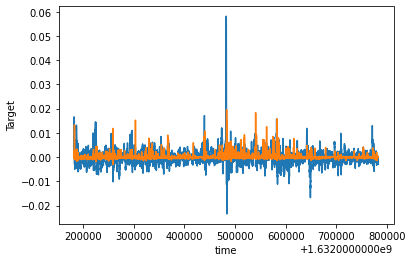

In [8]:
plt.xlabel("time")
plt.ylabel("Target")

plt.plot(id_list, y_test_list, label='Target')
plt.plot(id_list, y_pred_list, label='Prediction')

plt.show()